In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


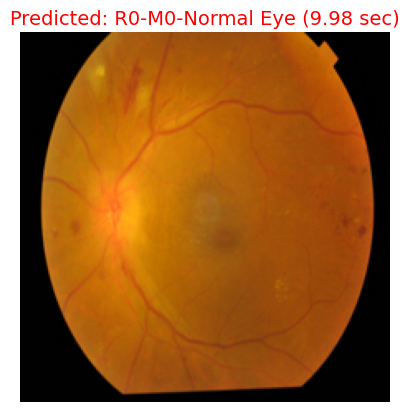

Predicted Class: R0-M0-Normal Eye
Processing Time: 9.98 seconds


In [ ]:
import tensorflow as tf
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import os

# Load trained models
model_paths = [
    "/content/drive/My Drive/DRdataset/Model_Save/MobileNetV2V1.keras",
    "/content/drive/My Drive/DRdataset/Model_Save/EfficientNetB0V1.keras"

]
models = [tf.keras.models.load_model(path) for path in model_paths]

# Load class indices from JSON
class_indices_path = "/content/drive/My Drive/DRdataset/Model_Save/class_indices.json"
with open(class_indices_path, 'r') as f:
    class_indices = json.load(f)

# Reverse dictionary for class name lookup
class_names = {v: k for k, v in class_indices.items()}  # {0: 'No DR', 1: 'Mild', 2: 'Moderate', ...}

# Function to load and preprocess an image from URL or local path
def load_image(image_path):
    if image_path.startswith("http"):  # Check if input is a URL
        response = requests.get(image_path)
        img = Image.open(BytesIO(response.content)).convert("RGB")
    else:  # Load from local file
        img = Image.open(image_path).convert("RGB")

    img = img.resize((224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    return img, img_array  # Return both original and processed image

# Function for ensemble prediction (returns class name & processing time)
def predict_class(image_path):
    original_img, img_array = load_image(image_path)

    # Measure processing time
    start_time = time.time()
    predictions = np.mean([model.predict(img_array) for model in models], axis=0)
    processing_time = time.time() - start_time  # Calculate time taken

    predicted_class = np.argmax(predictions)  # Get class index
    predicted_label = class_names.get(predicted_class, "Unknown")  # Convert to class name

    # Display the image with the predicted class
    plt.imshow(original_img)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label} ({processing_time:.2f} sec)", fontsize=14, color="red")
    plt.show()

    print(f"Predicted Class: {predicted_label}")
    print(f"Processing Time: {processing_time:.2f} seconds")

# Run prediction with a local image
predict_class("/content/drive/My Drive/DRdataset/Batch13/R2-M1-Moderate DR/IM000041.JPG")




In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load the trained model
model = tf.keras.models.load_model("/content/drive/My Drive/DRdataset/Model_Save/densenet_model.keras")

# Load and preprocess an image
def load_and_preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))  # Resize to match model input size
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array  # Return both original and preprocessed image

# Get class indices from dataset
class_indices = train_generator.class_indices  # {'Class_A': 0, 'Class_B': 1, 'Class_C': 2}
class_names = {v: k for k, v in class_indices.items()}  # {0: 'Class_A', 1: 'Class_B', 2: 'Class_C'}

# Provide image path
img_path = "/content/drive/My Drive/DRdataset/Split_DatasetV1/train/Not DR/IM000103.JPG"
original_img, img_array = load_and_preprocess_image(img_path)

# Predict using the model
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)  # Get class index

# Get class name from model mapping
predicted_label = class_names.get(predicted_class, "Unknown")

# Display the image with the predicted label
plt.imshow(original_img)
plt.axis("off")
plt.title(f"Predicted: {predicted_label}", fontsize=14, color="red")
plt.show()


TypeError: Could not locate function 'focal_loss_fixed'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'focal_loss_fixed', 'registered_name': 'function'}

**Dataset Load**

In [ ]:
import tensorflow as tf
import os

# Change this path according to your dataset's location in Google Drive
dataset_path = "/content/drive/MyDrive/DRdataset/Dataset_Phase_1/DatasetV3"




**Split Dataset**

Not run (I just used to seperate the train test val)

In [ ]:
import os
import shutil
import random

# Set paths
dataset_path = "/content/drive/MyDrive/DRdataset/Dataset_Phase_1/DatasetV3"
output_path = "/content/drive/MyDrive/DRdataset/Split_Datasetnew"

# Create output directories
for split in ["train", "test", "val"]:
    os.makedirs(os.path.join(output_path, split), exist_ok=True)

# Define split ratios
train_ratio = 0.6
test_ratio = 0.2
val_ratio = 0.2

# Loop through each class folder
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):  # Ensure it's a directory
        files = os.listdir(class_path)
        random.shuffle(files)  # Shuffle files to ensure randomness

        # Compute split sizes
        train_split = int(len(files) * train_ratio)
        test_split = int(len(files) * test_ratio)

        # Assign files
        train_files = files[:train_split]
        test_files = files[train_split:train_split + test_split]
        val_files = files[train_split + test_split:]

        # Move files into respective folders
        for split, file_list in zip(["train", "test", "val"], [train_files, test_files, val_files]):
            split_class_path = os.path.join(output_path, split, class_name)
            os.makedirs(split_class_path, exist_ok=True)

            for file in file_list:
                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_path, file))

print("Dataset split completed successfully! 🎯")

Dataset split completed successfully! 🎯


Noise reduction with GaussianBlur, medianBlur

Apply CLAHE

Apply Augmentation

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Image Preprocessing (Noise Reduction + CLAHE)
def preprocess_image(img):
    img = cv2.resize(img, (128, 128))  # Resize image
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.medianBlur(img, 3)

    # CLAHE (Enhance Contrast)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    img_lab = cv2.merge((l, a, b))
    img = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

    return img

# Load Data with Augmentation
def load_data(dataset_path, img_size=(224, 224), batch_size=32, augment=False):
    if augment:
        datagen = ImageDataGenerator(
             rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,  # Increase zoom range
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Adjust brightness
    fill_mode='nearest'
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
        dataset_path,
        target_size=img_size,
        color_mode="rgb",  # Use RGB instead of grayscale
        batch_size=batch_size,
        class_mode="categorical"
    )

# Dataset Paths
train_path = train_dir
valid_path = val_dir
test_path = test_dir

# Load Data
train_data = load_data(train_path, augment=True)
valid_data = load_data(valid_path)
test_data = load_data(test_path)

num_classes = len(train_data.class_indices)

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

**Save Directory**

In [ ]:

# Define a directory in Google Drive
save_dir = "/content/drive/My Drive/DRdataset/Model_Save"

**Focal Loss, Cross-Entropy Loss, and Weighted Average:**







In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K

# Define Focal Loss function
def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.
    gamma -- focusing parameter
    alpha -- balancing factor
    """
    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to prevent NaNs and Infs
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Cross-entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Focal loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)

    return focal_loss_fixed

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import os
import json

In [ ]:
pip install Augmentor

In [ ]:
import Augmentor

In [ ]:
#train Image
p=Augmentor.Pipeline("/content/drive/My Drive/DRdataset/Split_Datasetnew/train/", output_directory="/content/drive/My Drive/DRdataset/Split_Datasetnew/train/output")

Initialised with 1276 image(s) found.
Output directory set to /content/drive/My Drive/DRdataset/Split_Datasetnew/train/output.

In [ ]:
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

p.sample(1000)

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3380x2600 at 0x7D877A87BF10>: 100%|██████████| 1000/1000 [17:50<00:00,  1.07s/ Samples]


In [ ]:
#train Image
q=Augmentor.Pipeline("/content/drive/My Drive/DRdataset/Split_Datasetnew/test", output_directory="/content/drive/My Drive/DRdataset/Split_Datasetnew/test/output")

Initialised with 549 image(s) found.
Output directory set to /content/drive/My Drive/DRdataset/Split_Datasetnew/test/output.

In [ ]:
q.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

q.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

q.sample(1000)

Processing <PIL.Image.Image image mode=RGB size=3380x2600 at 0x7D87768E9310>: 100%|██████████| 1000/1000 [17:20<00:00,  1.04s/ Samples]


In [ ]:
#train Image
r=Augmentor.Pipeline("/content/drive/My Drive/DRdataset/Split_Datasetnew/val", output_directory="/content/drive/My Drive/DRdataset/Split_Datasetnew/val/output")

Initialised with 555 image(s) found.
Output directory set to /content/drive/My Drive/DRdataset/Split_Datasetnew/val/output.

In [ ]:
#Val Image
r=Augmentor.Pipeline("/content/drive/My Drive/DRdataset/Split_Datasetnew/val", output_directory="/content/drive/My Drive/DRdataset/Split_Datasetnew/val/output")
r.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

r.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)

r.sample(1000)

Initialised with 555 image(s) found.
Output directory set to /content/drive/My Drive/DRdataset/Split_Datasetnew/val/output.

Processing <PIL.Image.Image image mode=RGB size=3380x2600 at 0x7D8776650C50>:  72%|███████▏  | 722/1000 [12:54<04:58,  1.07s/ Samples]


KeyboardInterrupt: 

In [ ]:
data_dir = "/content/drive/My Drive/DRdataset/Split_Datasetnew/train/output"

data_dir_val = "/content/drive/My Drive/DRdataset/Split_Datasetnew/val/output"
data_dir_test = "/content/drive/My Drive/DRdataset/Split_Datasetnew/test/output"

In [ ]:
img_height=224  # For Densenet
img_width=224
batch_size=32

**DenseNet201**

In [ ]:


# Load DenseNet201 pre-trained model without the top classification layer
densenet_model = tf.keras.applications.DenseNet201(
    include_top=False,  # Exclude the final classification layers
    input_shape=(224, 224, 3),  # Resize input to 224x224
    weights='imagenet'  # Pre-trained on ImageNet
)

# Freeze the base model (no updates to the weights)
densenet_model.trainable = False

# Create the custom model on top of DenseNet201
model = models.Sequential([
    densenet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.002)),  # Stronger L2 Regularization
    layers.Dropout(0.5),  # Increased Dropout (50%)
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.002)),  # Additional Regularized Layer
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')  # Adjust this based on your task
])

# Compile Model before training
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower LR for stable learning
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# Callbacks: Early Stopping & ReduceLROnPlateau
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train Model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,  # Try more epochs for better learning
    callbacks=callbacks_list
)

# Unfreeze some layers for fine-tuning
densenet_model.trainable = True
for layer in densenet_model.layers[:-50]:  # Keep the first layers frozen
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),  # Fine-tuning with a lower LR
      loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-Tuning Model
history_fine = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=callbacks_list
)

# Define save directory for the model


# Save the trained model
model_path = os.path.join(save_dir, "densenet_model.keras")
model.save(model_path)

# Save training history in JSON format
history_path_json = os.path.join(save_dir, "densenet_history.json")
with open(history_path_json, 'w') as f:
    json.dump(history_fine.history, f)


NameError: name 'tf' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Define constants
IMG_SIZE = 600  # EfficientNetB7 expects large images
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 5  # Adjust based on the number of grading levels

# Load EfficientNetB7 base model
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model layers initially

# Build model
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Data augmentation and loading
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30,
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   horizontal_flip=True, zoom_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='sparse')
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='sparse')

# Train model
model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Fine-tuning (Unfreeze base model and train with a lower learning rate)
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=10)  # Fine-tune for 10 more epochs

# Save model
model.save('efficientnet_b7_diabetic_retinopathy.h5')


**InceptionV3**


In [ ]:

num_classes = train_data.num_classes
# Load InceptionV3 pre-trained model without the top classification layer
InceptionV3_model = tf.keras.applications.InceptionV3(
    include_top=False,  # Exclude the final classification layers
    input_shape=(224, 224, 3),  # Resize input to 224x224
    weights='imagenet'  # Pre-trained on ImageNet
)

# Freeze the base model (no updates to the weights)
InceptionV3_model.trainable = False

# Create the custom model on top of InceptionV3
model = models.Sequential([
    InceptionV3_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.002)),  # Stronger L2 Regularization
    layers.Dropout(0.5),  # Increased Dropout (50%)
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.002)),  # Additional Regularized Layer
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower LR for stable learning
    loss= focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# Callbacks: Early Stopping & ReduceLROnPlateau
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train Model
history = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=20,  # Try more epochs for better learning
    callbacks=callbacks_list
)

# Unfreeze Last Layers for Fine-Tuning
InceptionV3_model.trainable = True
for layer in InceptionV3_model.layers[:-50]:  # Keep first layers frozen
    layer.trainable = False

# Recompile with Lower LR
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# Fine-Tune Model
history_fine_inception = model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=callbacks_list
)

# Define save directory for the model
  # Adjust this path as needed

# Save the trained model
model_path = os.path.join(save_dir, "inceptionv3_model.keras")
model.save(model_path)
#keras.saving.save_model(model, 'inceptionv3_model.keras')

# Save training history in JSON format
history_path_json = os.path.join(save_dir, "inceptionv3_history.json")
with open(history_path_json, 'w') as f:
    json.dump(history_fine_inception.history, f)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 77s 7s/step - accuracy: 0.1856 - loss: 4.5200 - val_accuracy: 0.1795 - val_loss: 4.3529 - learning_rate: 1.0000e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.3422 - loss: 4.3475 - val_accuracy: 0.3077 - val_loss: 4.2718 - learning_rate: 1.0000e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.2332 - loss: 4.3064 - val_accuracy: 0.2564 - val_loss: 4.2397 - learning_rate: 1.0000e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.2930 - loss: 4.2490 - val_accuracy: 0.2821 - val_loss: 4.1698 - learning_rate: 1.0000e-04
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.2389 - loss: 4.1980 - val_accuracy: 0.2308 - val_loss: 4.1263 - learning_rate: 1.0000e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.2408 - loss: 4.1473 - val_accuracy: 0.4103 - val_loss: 4.0631 - learning_rate: 1.0000e-04
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.3530 - loss: 4.0852 - val_

**EfficientNetB3**

In [ ]:



# Define num_classes based on the number of classes in your dataset
num_classes = 10  # Adjust this to your specific dataset

# Load EfficientNetB3 pre-trained model without the top classification layer
EfficientNetB7_model = tf.keras.applications.EfficientNetB7(
    include_top=False,  # Exclude the final classification layers
    input_shape=(300, 300, 3),  # Resize input to 224x224
    weights='imagenet'  # Pre-trained on ImageNet
)

# Freeze the base model (no updates to the weights)
EfficientNetB7_model.trainable = False

# Create the custom model on top of EfficientNetB3
model = models.Sequential([
    EfficientNetB7_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.002)),  # Stronger L2 Regularization
    layers.Dropout(0.5),  # Increased Dropout (50%)
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.002)),  # Additional Regularized Layer
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for stable learning
  #  loss='categorical_crossentropy',  # Cross-entropy loss for multi-class classification
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# Callbacks: Early Stopping & ReduceLROnPlateau
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,  # Train for 20 epochs, adjust as necessary
    callbacks=callbacks_list
)

# Unfreeze Last Layers for Fine-Tuning
EfficientNetB7_model.trainable = True
for layer in EfficientNetB7_model.layers[:-50]:  # Keep first layers frozen and unfreeze the top 50 layers
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
    #loss='categorical_crossentropy',
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# Fine-Tune the model
history_fine_efficientnet = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Fine-tune for 10 more epochs
    callbacks=callbacks_list
)

# Define save directory for the model
 # Adjust this path as needed

# Save the trained model
model_path = os.path.join(save_dir, "efficientnet_model7.keras")
model.save(model_path)

# Save the training history in JSON format
history_path_json = os.path.join(save_dir, "efficientnet_history7.json")
with open(history_path_json, 'w') as f:
    json.dump(history_fine_efficientnet.history, f)


Epoch 1/30


UnknownError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
Error in user-defined function passed to ParallelMapDatasetV2:68 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'

Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/__autograph_generated_fileh6k35gw8.py", line 11, in <lambda>
    image, label = ag__.converted_call(ag__.ld(tf).py_function, (), dict(func=ag__.autograph_artifact(lambda x, y: ag__.converted_call(ag__.ld(preprocess_image), (ag__.ld(x), ag__.ld(y), ag__.ld(is_training)), None, fscope)), inp=[ag__.ld(image), ag__.ld(label)], Tout=(ag__.ld(tf).float32, ag__.ld(tf).int32)), fscope)
                                                                                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 460, in _call_unconverted
    return f(*args)
           ^^^^^^^^

  File "<ipython-input-28-79f46cc64a62>", line 37, in preprocess_image
    image_np = clahe_processing(image_np)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-28-79f46cc64a62>", line 23, in clahe_processing
    image_np = clahe.apply(image_np)
               ^^^^^^^^^^^^^^^^^^^^^

cv2.error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'



	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_75165]

In [ ]:
# Class weights

train_labels = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(train_labels),
                                                y=train_labels)
class_weights = dict(enumerate(class_weights))

# ----------------------------------
# Model Architecture (EfficientNet-B3)
# ----------------------------------

def build_model():
    base_model = tf.keras.applications.EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape=(300,300, 3)
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

model = build_model()

# ------------------
# Training Setup
# ------------------

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
]

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Phase 1: Train head
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

# Phase 2: Fine-tune
model.layers[1].trainable = True
for layer in model.layers[1].layers[:150]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,


    callbacks=callbacks
)
# -----------------
# Grad-CAM Visualization
# -----------------

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='top_conv'):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Example usage:
# img_array = ... # preprocessed image
# heatmap = make_gradcam_heatmap(img_array, model)


UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:68 transformation with iterator: Iterator::Root::Prefetch::BatchV2::Shuffle::ParallelMapV2: error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'

Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/__autograph_generated_fileh6k35gw8.py", line 11, in <lambda>
    image, label = ag__.converted_call(ag__.ld(tf).py_function, (), dict(func=ag__.autograph_artifact(lambda x, y: ag__.converted_call(ag__.ld(preprocess_image), (ag__.ld(x), ag__.ld(y), ag__.ld(is_training)), None, fscope)), inp=[ag__.ld(image), ag__.ld(label)], Tout=(ag__.ld(tf).float32, ag__.ld(tf).int32)), fscope)
                                                                                                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 335, in converted_call
    return _call_unconverted(f, args, kwargs, options, False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/autograph/impl/api.py", line 460, in _call_unconverted
    return f(*args)
           ^^^^^^^^

  File "<ipython-input-28-79f46cc64a62>", line 37, in preprocess_image
    image_np = clahe_processing(image_np)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "<ipython-input-28-79f46cc64a62>", line 23, in clahe_processing
    image_np = clahe.apply(image_np)
               ^^^^^^^^^^^^^^^^^^^^^

cv2.error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/clahe.cpp:353: error: (-215:Assertion failed) _src.type() == CV_8UC1 || _src.type() == CV_16UC1 in function 'apply'



	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

**Swin transfer**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import SwinForImageClassification, SwinConfig
from transformers import AutoTokenizer, AutoFeatureExtractor
from tensorflow.keras import layers, models
import timm

In [ ]:

!pip install transformers timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 981.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
# Define Focal Loss Function
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce_loss)
        return alpha * (1 - pt) ** gamma * ce_loss
    return loss

In [ ]:
# Load Swin Transformer Model from TIMM
def SwinTransformerModel(input_shape=(224, 224, 3), num_classes=num_classes):
    swin_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    x = GlobalAveragePooling2D()(swin_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=swin_model.input, outputs=output)
    return model

# Load Model
swin_model = SwinTransformerModel()

# Compile Model
#swin_model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])



# Recompile Model for Fine-Tuning
swin_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),  # Lower LR for fine-tuning
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)
# Callbacks for Training
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Fine-Tuning Training
history_fine = swin_model.fit(
    train_data,
    validation_data=valid_data,
    epochs=10,
    callbacks=callbacks_list
)

# Save Model

os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "swin_transformer_model.keras")
model.save(model_path)

# Save Training History
history_path_json = os.path.join(save_dir, "swin_transformer_history.json")
with open(history_path_json, 'w') as f:
    json.dump(history_fine.history, f)

print(f"✅ Model saved at: {model_path}")
print(f"✅ Training history saved at: {history_path_json}")





Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.1085 - loss: 0.4588 - val_accuracy: 0.1026 - val_loss: 0.4619 - learning_rate: 1.0000e-05
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.1097 - loss: 0.4420 - val_accuracy: 0.1538 - val_loss: 0.4415 - learning_rate: 1.0000e-05
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - accuracy: 0.1402 - loss: 0.4026 - val_accuracy: 0.1538 - val_loss: 0.4238 - learning_rate: 1.0000e-05
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.1600 - loss: 0.3773 - val_accuracy: 0.1538 - val_loss: 0.4040 - learning_rate: 1.0000e-05
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.1548 - loss: 0.3680 - val_accuracy: 0.1538 - val_loss: 0.3905 - learning_rate: 1.0000e-05
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.3369 - loss: 0.3225 - val_accuracy: 0.1538 - val_loss: 0.3811 - learning_rate: 1.0000e-05
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.2522 - loss: 0.3053 - val_

**Ensemble weighted Averaging**

In [ ]:
# Freeze the base models to prevent training of weights initially
InceptionV3_model.trainable = False
densenet_model.trainable = False
EfficientNetB3_model.trainable = False

# Create the ensemble model
inputs = layers.Input(shape=(224, 224, 3))

# Get feature maps from each base model
inception_output = InceptionV3_model(inputs)
densenet_output = densenet_model(inputs)
efficientnet_output = EfficientNetB3_model(inputs)

# Apply Global Average Pooling to each model's output
inception_output = layers.GlobalAveragePooling2D()(inception_output)
densenet_output = layers.GlobalAveragePooling2D()(densenet_output)
efficientnet_output = layers.GlobalAveragePooling2D()(efficientnet_output)

# Concatenate the outputs from all three models
ensemble_output = layers.Concatenate()([inception_output, densenet_output, efficientnet_output])

# Add Dense layers for final prediction
ensemble_output = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.002))(ensemble_output)
ensemble_output = layers.Dropout(0.5)(ensemble_output)
ensemble_output = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.002))(ensemble_output)
ensemble_output = layers.Dropout(0.3)(ensemble_output)

# Final output layer with softmax activation (for multi-class classification)
final_output = layers.Dense(num_classes, activation='softmax')(ensemble_output)

# Build the model
ensemble_model = models.Model(inputs=inputs, outputs=final_output)

# Compile the model with a low learning rate
ensemble_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Lower LR for stable learning
    loss='categorical_crossentropy',  # Multi-class classification
    metrics=['accuracy']
)

# Callbacks: Early Stopping & ReduceLROnPlateau
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# Train the Ensemble Model
history = ensemble_model.fit(
    train_data,  # Use your actual training data
    validation_data=valid_data,  # Use your actual validation data
    epochs=20,  # Train for a few more epochs to refine the model
    callbacks=callbacks_list
)

# Unfreeze the base models for fine-tuning
InceptionV3_model.trainable = True
densenet_model.trainable = True
EfficientNetB3_model.trainable = True

# Freeze all layers except the last 50
for layer in InceptionV3_model.layers[:-50]:
    layer.trainable = False
for layer in densenet_model.layers[:-50]:
    layer.trainable = False
for layer in EfficientNetB3_model.layers[:-50]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
ensemble_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the ensemble model
history_fine_tune = ensemble_model.fit(
    train_data,  # Use your actual training data
    validation_data=valid_data,  # Use your actual validation data
    epochs=10,
    callbacks=callbacks_list
)




# Save the trained model
model_path = os.path.join(save_dir, "ensemble_model.keras")
model.save(model_path)

# Save training history in JSON format
history_path_json = os.path.join(save_dir, "ensemble_history.json")
with open(history_path_json, 'w') as f:
    json.dump(history_fine.history, f)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 262s 26s/step - accuracy: 0.2320 - loss: 6.7187 - val_accuracy: 0.3333 - val_loss: 6.3826 - learning_rate: 1.0000e-04
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 248s 26s/step - accuracy: 0.2876 - loss: 6.5364 - val_accuracy: 0.4103 - val_loss: 6.2624 - learning_rate: 1.0000e-04
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 172s 21s/step - accuracy: 0.2580 - loss: 6.4918 - val_accuracy: 0.4359 - val_loss: 6.1286 - learning_rate: 1.0000e-04
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 221s 24s/step - accuracy: 0.3875 - loss: 6.2009 - val_accuracy: 0.4615 - val_loss: 6.0155 - learning_rate: 1.0000e-04
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 182s 21s/step - accuracy: 0.3109 - loss: 6.1326 - val_accuracy: 0.5128 - val_loss: 5.9057 - learning_rate: 1.0000e-04
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 174s 22s/step - accuracy: 0.3335 - loss: 6.0738 - val_accuracy: 0.4359 - val_loss: 5.8376 - learning_rate: 1.0000e-04
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 174s 22s/step - accuracy: 0.3830 - loss:

**Confusion Matrix**

Model loaded successfully!
3/3 ━━━━━━━━━━━━━━━━━━━━ 72s 18s/step


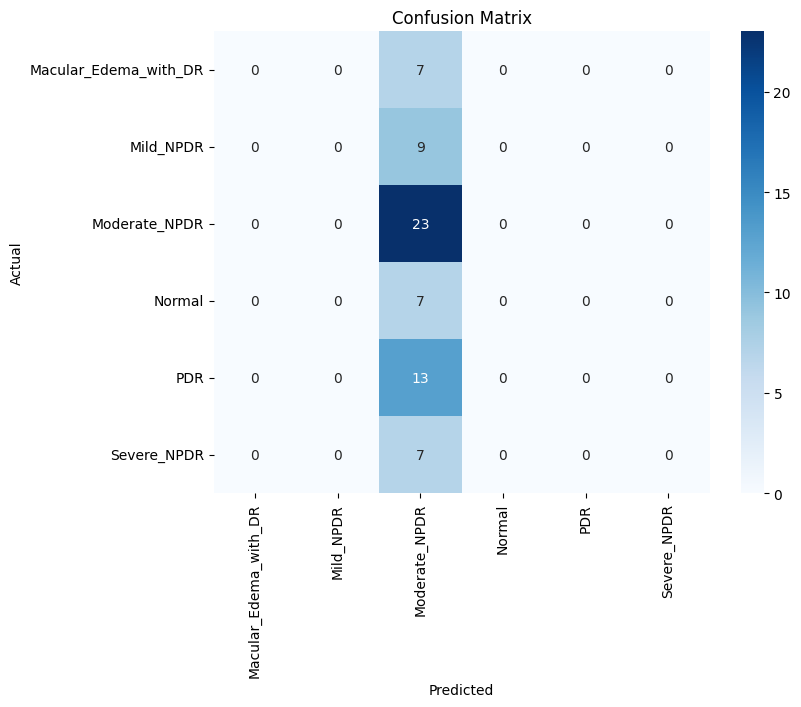

                       precision    recall  f1-score   support

Macular_Edema_with_DR       0.00      0.00      0.00         7
            Mild_NPDR       0.00      0.00      0.00         9
        Moderate_NPDR       0.35      1.00      0.52        23
               Normal       0.00      0.00      0.00         7
                  PDR       0.00      0.00      0.00        13
          Severe_NPDR       0.00      0.00      0.00         7

             accuracy                           0.35        66
            macro avg       0.06      0.17      0.09        66
         weighted avg       0.12      0.35      0.18        66



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:


import tensorflow as tf

# Define model path
model_path = "/content/drive/MyDrive/DRdataset/Model_Save/ensemble_model.keras"  # Update the path accordingly

# Load the model
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully!")



import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load the test dataset
test_images, test_labels = [], []
for images, labels in test_ds:
    # Resize images to match the model's input shape
    resized_images = tf.image.resize(images, (224, 224))
    test_images.append(resized_images.numpy())
    test_labels.append(labels.numpy())

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Predict using the trained model
y_pred_probs = model.predict(test_images)  # Replace `model` with your trained model
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices
y_true = test_labels  # True class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = test_ds.class_names  # Get class names

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))


*** Grad-CAM Implementation***

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
33188688/33188688 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
123465288/123465288 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_7426']
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
<ipython-input-9-172c739ef5cd>:63: RuntimeWarning: invalid value encountered in divide
  heatmap /= np.max(heatmap)  # Normalize
<ipython-input-9-172c739ef5cd>:77: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


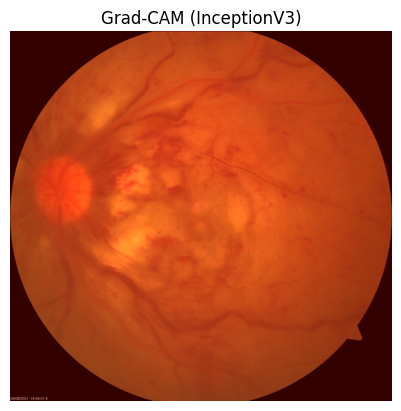

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, DenseNet121, EfficientNetB5
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image

# Load Pre-trained Models
inception_model = InceptionV3(weights='imagenet')
densenet_model = DenseNet121(weights='imagenet')
efficientnet_model = EfficientNetB5(weights='imagenet')

# Select one of the models (InceptionV3 in this case for Grad-CAM)
model = inception_model  # Change to DenseNet or EfficientNet if needed

# Preprocessing function for the image (specific to the model)
def preprocess_input_for_model(img, model_name):
    if model_name == "InceptionV3":
        return tf.keras.applications.inception_v3.preprocess_input(img)
    elif model_name == "DenseNet":
        return tf.keras.applications.densenet.preprocess_input(img)
    elif model_name == "EfficientNet":
        return tf.keras.applications.efficientnet.preprocess_input(img)
    else:
        raise ValueError("Unsupported model")

# Function to load and preprocess image
def load_and_preprocess_image(img_path, model_name):
    img = image.load_img(img_path, target_size=(299, 299))  # For InceptionV3
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input_for_model(img_array, model_name)

# Grad-CAM Implementation
def grad_cam(model, img_array, class_idx):
    # Get the last convolutional layer name
    # Updated to use 'mixed10' which is the last convolutional layer in InceptionV3
    last_conv_layer = model.get_layer("mixed10")
    grad_model = models.Model(inputs=[model.input], outputs=[last_conv_layer.output, model.output])

    # Get the gradient of the class output with respect to the last conv layer
    with tf.GradientTape() as tape:
        last_conv_output, predictions = grad_model(img_array)
        class_channel = predictions[:, class_idx]

    # Get the gradients of the class output with respect to the last conv layer
    grads = tape.gradient(class_channel, last_conv_output)

    # Pool the gradients across all the channels of the last conv layer
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map by how important this channel is for the class prediction
    last_conv_output = last_conv_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()

    for i in range(last_conv_output.shape[-1]):
        last_conv_output[:, :, i] *= pooled_grads[i]

    # Create the heatmap
    heatmap = np.mean(last_conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# Function to display Grad-CAM heatmap
def display_grad_cam_heatmap(img_path, heatmap, model_name):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Resize heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply heatmap to the image
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img  # Superimpose the heatmap on the image

    # Display the image with heatmap
    plt.imshow(superimposed_img / 255.)
    plt.axis('off')
    plt.title(f"Grad-CAM ({model_name})")
    plt.show()

# Example usage
img_path = '/content/drive/MyDrive/DRdataset/Split_Dataset/train/PDR/2062.jpg'  # Provide path to the image you want to process
img_array = load_and_preprocess_image(img_path, model_name="InceptionV3")

# Perform Grad-CAM for the class you're interested in (for example, class 0)
class_idx = 0  # Change as per your class of interest
heatmap = grad_cam(model, img_array, class_idx)

# Display Grad-CAM heatmap
display_grad_cam_heatmap(img_path, heatmap, model_name="InceptionV3")

Swim Transfer Model Grad Cham

In [ ]:
import torch
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Load Pretrained Swin Transformer
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=True)
model.eval()

# Hook function to capture attention weights
attention_maps = []

def get_attention(module, input, output):
    # Check if the output tensor has 4 dimensions (batch, heads, seq_len, seq_len)
    if output.dim() == 4:
        # Average over heads and reshape to (batch, seq_len, seq_len)
        attn_map = output.mean(dim=1).squeeze(0)  # Assuming batch size of 1
        attention_maps.append(attn_map.detach())  # Store the attention map

# Register hooks to capture attention from all transformer layers
for name, module in model.named_modules():
    if "attn" in name:  # Find attention layers
        module.register_forward_hook(get_attention)

# Image Preprocessing (unchanged)
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# Attention Rollout (Computing Heatmap) - Modified
def compute_attention_rollout(attention_maps):
    # Stack all attention layers (now with consistent shapes)
    print(attention_maps)
    attention = torch.stack(attention_maps)

    # (Rest of the function remains the same)
    attention = attention.mean(dim=0)  # Average over layers
    attention = attention.numpy()
    heatmap = attention[-1, 1:].reshape(14, 14)  # Remove CLS token, reshape to 14x14
    heatmap = cv2.resize(heatmap, (224, 224))  # Resize to match image size
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalize
    return heatmap

# Overlay Heatmap on Image (unchanged)
def overlay_heatmap(img, heatmap):
    heatmap = np.uint8(255 * heatmap)  # Convert to uint8
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply colormap
    superimposed_img = cv2.addWeighted(np.array(img), 0.6, heatmap, 0.4, 0)

    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM for Swin Transformer")
    plt.show()

# Run Grad-CAM for Swin Transformer (unchanged)
img_path = "/content/drive/MyDrive/DRdataset/Split_Dataset/train/PDR/2062.jpg"  # Change to your image path
img, img_tensor = preprocess_image(img_path)

with torch.no_grad():
    model(img_tensor)

heatmap = compute_attention_rollout(attention_maps)
overlay_heatmap(img, heatmap)


[tensor([[[0.0063, 0.2542, 0.0238,  ..., 0.0126, 0.0111, 0.0166],
         [0.0500, 0.0061, 0.2338,  ..., 0.0113, 0.0121, 0.0106],
         [0.0301, 0.0481, 0.0058,  ..., 0.0130, 0.0108, 0.0115],
         ...,
         [0.0113, 0.0115, 0.0127,  ..., 0.0054, 0.2218, 0.0205],
         [0.0113, 0.0114, 0.0116,  ..., 0.0460, 0.0055, 0.2225],
         [0.0159, 0.0116, 0.0113,  ..., 0.0402, 0.0801, 0.0054]],

        [[0.0079, 0.2574, 0.0289,  ..., 0.0024, 0.0019, 0.0027],
         [0.0565, 0.0073, 0.2365,  ..., 0.0021, 0.0020, 0.0015],
         [0.0355, 0.0548, 0.0071,  ..., 0.0025, 0.0018, 0.0017],
         ...,
         [0.0055, 0.0058, 0.0064,  ..., 0.0149, 0.2489, 0.0536],
         [0.0048, 0.0048, 0.0051,  ..., 0.0951, 0.0145, 0.2455],
         [0.0060, 0.0045, 0.0042,  ..., 0.0795, 0.1334, 0.0150]],

        [[0.0241, 0.2925, 0.0836,  ..., 0.0043, 0.0035, 0.0059],
         [0.1333, 0.0222, 0.2704,  ..., 0.0037, 0.0036, 0.0034],
         [0.1012, 0.1375, 0.0225,  ..., 0.0046, 0.0034, 0

RuntimeError: stack expects each tensor to be equal size, but got [64, 49, 49] at entry 0 and [16, 49, 49] at entry 4